In [81]:
import pickle


def l2norm(list1, list2):
    l2_norm_difference = sum((x - y) ** 2 for x, y in zip(list1, list2)) ** 0.5
    l2_norm_reference = sum(y**2 for y in list1) ** 0.5
    return l2_norm_difference / l2_norm_reference


def get_record(cnum, dataset, model, setup):
    rec_path = f"./rec_fed_sample_time/{model}_model_{cnum}_{dataset}_{setup}.rec"
    with open(rec_path, "rb") as res_file:
        record = pickle.load(res_file)
    return record

# r = get_record(6, "emnist", "cnn", "same")
# for i in range(2 ** 6):
#     print(i, r[str(i)]["acc"])

In [ ]:
import os

from tqdm import tqdm
from helper_alg import IPSS_SHAP, MC_Random_SHAP, DEF_SHAP, TEST_SHAP

cnum = 6 # 3 6 10
dataset = "emnist"
model = "cnn" # cnn linear
setup = "same"
setting = (cnum, dataset, model, setup)

record = get_record(cnum, dataset, model, setup)
exact = DEF_SHAP(record, cnum, False)[0]
algs = {"IPSS": IPSS_SHAP, "MC-Random": MC_Random_SHAP}
data_filepath = f"ablation/data_{cnum}_{model}_{dataset}_{setup}.pk"
data = {}

if os.path.exists(data_filepath):
    with open(data_filepath, "rb") as data_file:
        data = pickle.load(data_file)
    gamma = 63
    acc, loss, acc_time, loss_time = MC_Random_SHAP(record, cnum, gamma, False)
    data["MC-Random"][gamma - 1] = (gamma, acc_time, l2norm(exact, acc))
    with open(data_filepath, "wb") as f:
        pickle.dump(data, f)
else:
    for alg in algs:
        tmp = []
        for gamma in tqdm(range(1, 2**cnum + 1), desc=alg):
            acc, loss, acc_time, loss_time = algs[alg](record, cnum, gamma, False)
            tmp.append((gamma, acc_time, l2norm(exact, acc)))
        data[alg] = tmp
    with open(data_filepath, "wb") as f:
        pickle.dump(data, f)

data

{'IPSS': [(1, 8.345846753567457, 1.0),
  (2, 28.227927405387163, 0.9307615299549754),
  (3, 49.944342294707894, 0.7986110174294565),
  (4, 69.1014015134424, 0.7906083901011571),
  (5, 88.85669867135584, 0.706368861687923),
  (6, 108.96831945516169, 0.5375010068924633),
  (7, 130.00984832458198, 0.25469401428209487),
  (8, 150.92540307343006, 0.2507578040736766),
  (9, 171.72727138735354, 0.24559344565363167),
  (10, 191.87473780289292, 0.23173764468815916),
  (11, 212.39561971835792, 0.23024713464996094),
  (12, 233.56203026138246, 0.19597205512494012),
  (13, 254.64200547896326, 0.23633910596226404),
  (14, 275.1488041654229, 0.2004776260945065),
  (15, 295.8255326356739, 0.17968458908165377),
  (16, 315.6239505186677, 0.1837077255423532),
  (17, 337.1877083219588, 0.18614843684451018),
  (18, 358.3057853151113, 0.17083911367261626),
  (19, 378.9372090213001, 0.1620582908822381),
  (20, 400.1514178272337, 0.16019605277741014),
  (21, 420.1982932481915, 0.1652594614387499),
  (22, 440.

In [83]:
import matplotlib.pylab as plt

# plt.style.use("ggplot")
# plt.rcParams["axes.prop_cycle"]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"

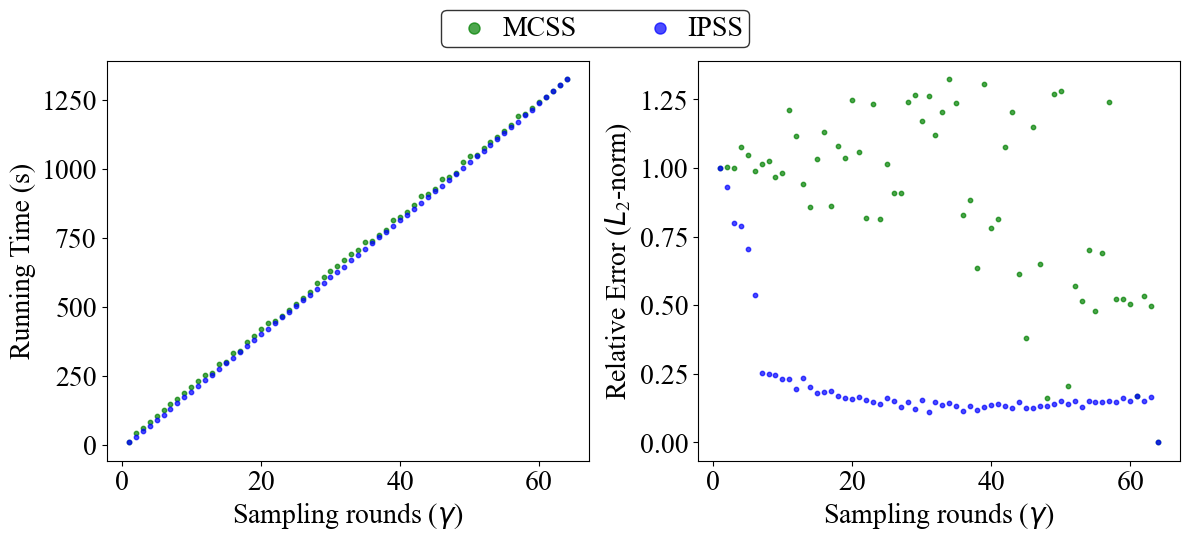

In [84]:
import math
import matplotlib.pyplot as plt

fontsize = 20
labelsize = 20
colors = {"IPSS": "blue", "MC-Random": "green", "CC-Random": "red"}
labels = {"IPSS": "IPSS", "MC-Random": "MCSS", "CC-Random": "CCSS"}
dot_size = {10: 5, 6: 10, 3: 50}[cnum]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes: list[plt.Axes]
ax1, ax2 = axes

for alg in ["MC-Random", "IPSS"]:
    gamma, time, error = zip(*data[alg])
    ax1.scatter(gamma, time, s=dot_size, color=colors[alg], label=labels[alg], alpha=0.7)
    ax2.scatter(gamma, error, s=dot_size, color=colors[alg], label=labels[alg], alpha=0.7)

ax1.set_xlabel("Sampling rounds ($\gamma$)", fontsize=fontsize)
ax1.set_ylabel("Running Time (s)", fontsize=fontsize)
ax1.tick_params(axis="both", labelsize=labelsize)

ax2.set_xlabel("Sampling rounds ($\gamma$)", fontsize=fontsize)
ax2.set_ylabel("Relative Error ($L_{2}$-norm)", fontsize=fontsize)
ax2.tick_params(axis="both", labelsize=labelsize)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=2,
    fontsize=labelsize,
    frameon=True,
    edgecolor="black",
    borderpad=0.2,
    handletextpad=0,
    markerscale=8 / math.sqrt(dot_size),
)

plt.tight_layout()
plt.savefig(f"figs/ablation/ablation_{cnum}_{model}_{dataset}_{setup}.png", bbox_inches="tight")
plt.show()